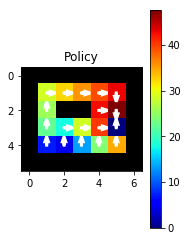

5 0
PDWDR= nan
5 1
PDWDR= nan
5 2
PDWDR= 25.7749591621
5 3
PDWDR= 24.4852755941
5 4


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/Users/wihl/Projects/Courses/17Fall/CS282/cs282-f17-xuefeng-yi-david/playground/autograd/rl_functions.py:376: RuntimeWarning: invalid value encountered in double_scalars
  estimator = np.sum( individual_trial_estimators ) / normalization
/Users/wihl/Projects/Courses/17Fall/CS282/cs282-f17-xuefeng-yi-david/playground/autograd/rl_functions.py:328: RuntimeWarning: invalid value encountered in double_scalars
  w = rho / weights_normalization[ t_within_trial ]
/Users/wihl/Projects/Courses/17Fall/CS282/cs282-f17-xuefeng-yi-david/playground/autograd/rl_functions.py:468: RuntimeWarning: invalid value encountered in double_scalars
  w = rho / weights_normalization[ t_within_trial ]


PDWDR= 24.7001651432
5 5
PDWDR= nan
5 6
PDWDR= nan
5 7
PDWDR= 24.9307939489
5 8
PDWDR= nan
5 9
PDWDR= nan
5 10
PDWDR= 29.0219423377
5 11
PDWDR= nan
5 12
PDWDR= 25.4567379309
5 13
PDWDR= 31.6590802632
5 14
PDWDR= 22.8416819724
5 15
PDWDR= nan
5 16
PDWDR= 20.5613209
5 17
PDWDR= 22.959695235
5 18
PDWDR= 23.0327524156
5 19
PDWDR= 27.287081382
10 0
PDWDR= 17.7248254904
10 1
PDWDR= 22.356875321
10 2
PDWDR= 25.2284241397
10 3
PDWDR= 22.8931703153
10 4
PDWDR= nan
10 5
PDWDR= 22.4448236585
10 6
PDWDR= nan
10 7
PDWDR= 26.356231528
10 8
PDWDR= 24.3886488755
10 9
PDWDR= 22.4691409157
10 10
PDWDR= 27.7894243517
10 11
PDWDR= 24.2535724709
10 12
PDWDR= nan
10 13
PDWDR= 24.6186873088
10 14
PDWDR= 26.7207559232
10 15
PDWDR= -1.66098324673
10 16
PDWDR= 18.8669097376
10 17
PDWDR= 18.8955713955
10 18
PDWDR= 27.315307386
10 19
PDWDR= 16.0432415664
20 0
PDWDR= 24.3118969874
20 1
PDWDR= 17.2198708151
20 2
PDWDR= 21.2401241977
20 3
PDWDR= 16.0351449994
20 4
PDWDR= 24.3148793073
20 5
PDWDR= 22.5000794822
20 6


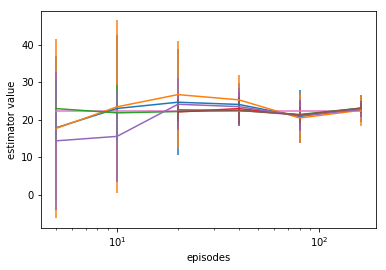

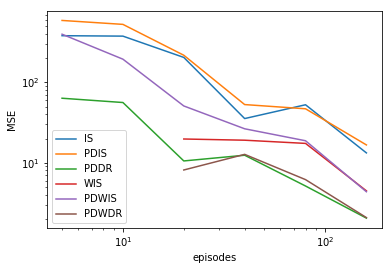

In [39]:
# general imports 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np

# created by us 
import gridworld 
import sys
sys.path.insert(0, '../')
import rl_functions as rlfun
from gridworld_generate_true_MDP import gridworld_true_MDP

np.set_printoptions( precision = 2 )

# ---------------------- #
#   Different Domains    #
# ---------------------- #
# You can also create your own!  The interpretation of the different symbols is
# the following:
#
# '#' = wall
# 'o' = origin grid cell
# '.' = empty grid cell
# '*' = goal
test_maze = [   # HERE: Make this one bigger, probably! 
    '#########',
    '#..#....#',
    '#..#..#.#',
    '#..#..#.#',
    '#..#.##.#',
    '#....*#.#',
    '#######.#',
    '#o......#',
    '#########']

cliffworld = [
    '#######', 
    '#.....#', 
    '#.##..#', 
    '#o...*#',
    '#XXXXX#', 
    '#######']    

short_hallway = [   
    '###', # '#' = wall
    '#o#', # 'o' = origin grid cell
    '#.#', # '.' = empty grid cell
    '#*#', # '*' = goal
    '###']

long_hallway = [   
    '###', # '#' = wall
    '#o#', # 'o' = origin grid cell
    '#.#', # '.' = empty grid cell
    '#.#', # '.' = empty grid cell
    '#.#', # '.' = empty grid cell
    '#.#', # '.' = empty grid cell
    '#.#', # '.' = empty grid cell
    '#.#', # '.' = empty grid cell
    '#.#', # '.' = empty grid cell
    '#*#', # '*' = goal
    '###']

simple_grid = [   
    '#######', 
    '#o....#', 
    '#..X..#', 
    '#....*#', 
    '#######']    

# ----------------- #
#   Key Functions   # 
# ----------------- #
# The policy outputs the action for each states 
#def policy( state , Q_table , action_count , epsilon ):
#    if np.random.random() < epsilon:
#        action = np.random.choice( action_count ) 
#    else: 
#        action = np.argmax( Q_table[ state , : ] ) 
#    return action 

# Takes in count table and updates it
def update_count_table( transition_count_table , reward_value_table , state , action , new_state , reward ):
    transition_count_table[ state, action, new_state ] += 1
    reward_value_table[ state, action, new_state ] = reward
    return transition_count_table , reward_value_table 

# Takes in counts and builds an MDP using the RMAX approach (unseen rewards set
# to rmax, use the empirical counts for the transition frequencies)
def build_MDP_RMAX( transition_count_table , reward_value_table , rmax , gamma ):
    state_count = np.shape( transition_count_table )[0]
    action_count = np.shape( transition_count_table )[1]
    state_action_observations = np.sum( transition_count_table, axis = 2 )
    state_action_observations = np.reshape( state_action_observations, 
        ( state_count, action_count, 1) )
    transition_matrix = transition_count_table / np.tile(
            state_action_observations, [ 1, 1, state_count ])
    indices_for_unobserved_transition_probabilities = np.tile(
            state_action_observations == 0, [ 1, 1, state_count ])
    transition_matrix[ indices_for_unobserved_transition_probabilities ] = \
        1/state_count 
    rewards_matrix = np.copy(reward_value_table)
    sas_not_observed = np.sum( transition_count_table, axis = (0,1) ) == 0
    rewards_matrix[ sas_not_observed ] = rmax
    MDP = {
        'T' : transition_matrix,
        'R' : rewards_matrix,
        'gamma' : gamma,
        'state_count' : state_count,
        'action_count' : action_count}
    return MDP

# Takes in counts and samples and MDP 
#def sample_MDP( transition_count_table , reward_value_table , Dirichlet_alpha , default_reward ):
#    state_count = np.shape( transition_count_table )[0]
#    action_count = np.shape( transition_count_table )[1]
#    state_action_observations = np.sum( transition_count_table, axis = 2 )
#    state_action_observations = np.reshape( state_action_observations, 
#        ( state_count, action_count, 1) )
#    transition_matrix = np.zeros( np.shape( transition_count_table ) )
#    for state_ind in range( state_count ):
#        for action_ind in range( action_count ):
#            transition_matrix[ state_ind, action_ind, : ] = \
#                np.random.dirichlet( transition_count_table[ state_ind, action_ind, : ] + \
#                Dirichlet_alpha )
#    rewards_matrix = np.copy(reward_value_table)
#    sas_not_observed = np.sum( transition_count_table, axis = (0,1) ) == 0
#    rewards_matrix[ sas_not_observed ] = default_reward
#    MDP = {
#        'T' : transition_matrix,
#        'R' : rewards_matrix,
#        'gamma' : gamma,
#        'state_count' : state_count,
#        'action_count' : action_count}
#    return MDP

# Solve MDP
def solve_MDP( MDP ):
    state_count = MDP['state_count']
    action_count = MDP['action_count']
    T = MDP['T']
    R = MDP['R']
    gamma = MDP['gamma']
    Q_table = np.zeros( ( state_count, action_count ) )
    V = np.zeros( state_count )
    for iter_number in range(200):
        for state_ind in range( state_count ):
            for action_ind in range( action_count ):
                expected_reward = np.sum(T[ state_ind, action_ind, : ] * \
                    R[ state_ind, action_ind, : ] )
                expected_value_of_next_state = np.sum( T[ state_ind, action_ind, : ] * V )
                Q_table[ state_ind, action_ind ] = expected_reward + \
                    gamma * expected_value_of_next_state
            V[ state_ind ] = np.max( Q_table[ state_ind, :] )
    return Q_table

# -------------------- #
#   Create the Task    #
# -------------------- #
# Task Parameters for gridworld 
task_name = cliffworld
action_error_prob = 0.2
pit_reward = -50
task = gridworld.GridWorld( task_name ,
                            action_error_prob=action_error_prob, 
                            rewards={'*': 50, 'moved': -1, 'hit-wall': -1,'X':pit_reward} ,
                            terminal_markers='*' )        

gamma = 0.95
state_count = task.num_states  
action_count = task.num_actions 
true_MDP = gridworld_true_MDP( task_name, action_error_prob, pit_reward, gamma )
Q_table = solve_MDP( true_MDP )

# -------------- #
#   Make Plots   #
# -------------- #
# Note, these are plots that are useful for visualizing the policies
# and the value functions, which can help you identify bugs.  You can
# also use them as a starting point to create the plots that you will
# need for your homework assignment.

# Util to make an arrow 
# The directions are [ 'north' , 'south' , 'east' , 'west' ] 
def plot_arrow( location , direction , plot ):

    arrow = plt.arrow( location[0] , location[1] , dx , dy , fc="k", ec="k", head_width=0.05, head_length=0.1 )
    plot.add_patch(arrow) 

# Useful stats for the plot
row_count = len( task_name )
col_count = len( task_name[0] ) 
value_function = np.reshape( np.max( Q_table , 1 ) , ( row_count , col_count ) )
policy_function = np.reshape( np.argmax( Q_table , 1 ) , ( row_count , col_count ) )
wall_info = .5 + np.zeros( ( row_count , col_count ) )
wall_mask = np.zeros( ( row_count , col_count ) )
for row in range( row_count ):
    for col in range( col_count ):
        if task_name[row][col] == '#':
            wall_mask[row,col] = 1     
wall_info = np.ma.masked_where( wall_mask==0 , wall_info )
value_function *= (1-wall_mask)**2

# value function plot 
plt.subplot( 1 , 2 , 2 ) 
plt.imshow( value_function , interpolation='none' , cmap=matplotlib.cm.jet )
plt.colorbar()
plt.imshow( wall_info , interpolation='none' , cmap=matplotlib.cm.gray )
plt.title( 'Value Function' )

# policy plot 
# plt.imshow( 1 - wall_mask , interpolation='none' , cmap=matplotlib.cm.gray )    
for row in range( row_count ):
    for col in range( col_count ):
        if wall_mask[row][col] == 1:
            continue 
        if policy_function[row,col] == 0:
            dx = 0; dy = -.5
        if policy_function[row,col] == 1:
            dx = 0; dy = .5
        if policy_function[row,col] == 2:
            dx = .5; dy = 0
        if policy_function[row,col] == 3:
            dx = -.5; dy = 0
        plt.arrow( col , row , dx , dy , shape='full', fc='w' , ec='w' , lw=3, length_includes_head=True, head_width=.2 )
plt.title( 'Policy' )        
plt.show( block=False ) 

# -------------------------- #
# Off-policy evaluation part #    
# -------------------------- #

episode_count__list = [ 5, 10, 20, 40, 80, 160]#, 360, 640, 1280, 2560 ]
num_of_tests = 20
epsilon = 0.2
pi_optimal = np.argmax( Q_table, axis = 1 )
pi_optimal = rlfun.turn_policy_to_stochastic_policy(
    pi_optimal, num_of_states = state_count, num_of_actions = action_count )
pi_random  = np.ones( (state_count, action_count) ) / action_count
pi_eps_greedy = pi_optimal * ( 1 - epsilon ) + epsilon / 4
pi_behavior = pi_eps_greedy
pi_eval = pi_optimal
#pi_behavior = pi_random
#pi_eval = pi_random


IS__list__list = []
PDIS__list__list = []
PDDR__list__list = []
WIS__list__list = []
PDWIS__list__list = []
PDWDR__list__list = []

max_task_iter = 100
rmax = task.get_max_reward()

for episode_count in episode_count__list:
    IS__list = []
    PDIS__list = []
    PDDR__list = []
    WIS__list = []
    PDWIS__list = []
    PDWDR__list = []
    for test_count in range(num_of_tests):
        global_task_iter = 0
        states_sequence = []
        actions_sequence = []
        rewards_sequence = []
        fence_posts = []
        transition_count_table = np.zeros( ( state_count , action_count , state_count ) )
        reward_value_table = np.zeros( ( state_count , action_count , state_count ) )
        print(episode_count, test_count)
        # Loop until the episode is done 
        for episode_iter in range( episode_count ):
            fence_posts += [ global_task_iter ]
            # Start the task 
            task.reset()
            state = task.observe() 
            action = np.random.choice( 4, 1, p = pi_behavior[ state, : ] )[0]
            episode_reward_list = []
            task_iter = 0 
        
            # Loop until done
            while task_iter < max_task_iter:
                global_task_iter += 1
                task_iter = task_iter + 1 
                new_state, reward = task.perform_action( action )
                new_action = np.random.choice( 4, 1, p = pi_behavior[ new_state, : ] )[0] 
        
                # Cases for the different algorithms 
                transition_count_table , reward_value_table = update_count_table( transition_count_table , reward_value_table , state , action , new_state , reward )
        
                # store the data
                episode_reward_list.append( reward ) 
                
                states_sequence += [ state ]
                actions_sequence += [ action ]
                rewards_sequence += [ reward ]

                # stop if at goal/else update for the next iteration 
                if task.is_terminal( state ):
                    break
                else:
                    state = new_state
                    action = new_action
            
                    
        MDP = build_MDP_RMAX( transition_count_table , reward_value_table , rmax , gamma )
        V, Q = rlfun.policy_evaluation(
                MDP['T'] , MDP['R'] , pi_eval , gamma , theta = 0.01 )
        
        IS, _ = rlfun.off_policy_importance_sampling(
            states_sequence, actions_sequence, rewards_sequence,
            fence_posts, gamma, pi_eval, pi_behavior, state_count,
            action_count)
        PDIS, _ = rlfun.off_policy_per_decision_importance_sampling(
            states_sequence, actions_sequence, rewards_sequence,
            fence_posts, gamma, pi_eval, pi_behavior, state_count,
            action_count)
        PDDR, _ = rlfun.off_policy_per_decision_doubly_robust(
            states_sequence, actions_sequence, rewards_sequence,
            fence_posts, gamma, pi_eval, pi_behavior, V, Q, state_count,
            action_count)
        WIS, ite = rlfun.off_policy_weighted_importance_sampling(
            states_sequence, actions_sequence, rewards_sequence,
            fence_posts, gamma, pi_eval, pi_behavior, state_count,
            action_count)
        PDWIS, ite = rlfun.off_policy_per_decision_weighted_importance_sampling(
            states_sequence, actions_sequence, rewards_sequence,
            fence_posts, gamma, pi_eval, pi_behavior, state_count,
            action_count)
        PDWDR, ite = rlfun.off_policy_per_decision_weighted_doubly_robust(
            states_sequence, actions_sequence, rewards_sequence,
            fence_posts, gamma, pi_eval, pi_behavior, V, Q, state_count,
            action_count)
        print ("PDWDR=",PDWDR)
        IS__list += [ IS ]
        PDIS__list += [ PDIS ]
        PDDR__list += [ PDDR ]
        WIS__list += [ WIS ]
        PDWIS__list += [ PDWIS ]
        PDWDR__list += [ PDWDR ]
    IS__list__list += [ IS__list ]
    PDIS__list__list += [ PDIS__list ]
    PDDR__list__list += [ PDDR__list ]
    WIS__list__list += [ WIS__list ]
    PDWIS__list__list += [ PDWIS__list ]
    PDWDR__list__list += [ PDWDR__list ]
    
IS__list__list = np.asarray(IS__list__list)
PDIS__list__list = np.asarray(PDIS__list__list)
PDDR__list__list = np.asarray(PDDR__list__list)
WIS__list__list = np.asarray(WIS__list__list)
PDWIS__list__list = np.asarray(PDWIS__list__list)
PDWDR__list__list = np.asarray(PDWDR__list__list)

V__true, Q__true = rlfun.policy_evaluation(
                true_MDP['T'] , true_MDP['R'] , pi_eval , gamma , theta = 0.01 )
actual_policy_value = V__true[ task.maze.flat_positions_containing('o')[0] ]
plt.figure()
plt.errorbar( episode_count__list, np.mean(IS__list__list, axis = 1 ),
             yerr = np.std(IS__list__list, axis = 1 ) )
plt.errorbar( episode_count__list, np.mean(PDIS__list__list, axis = 1 ),
             yerr = np.std(PDIS__list__list, axis = 1 ) )
plt.errorbar( episode_count__list, np.mean(PDDR__list__list, axis = 1 ),
             yerr = np.std(PDDR__list__list, axis = 1 ) )
plt.errorbar( episode_count__list, np.mean(WIS__list__list, axis = 1 ),
             yerr = np.std(WIS__list__list, axis = 1 ) )
plt.errorbar( episode_count__list, np.mean(PDWIS__list__list, axis = 1 ),
             yerr = np.std(PDWIS__list__list, axis = 1 ) )
plt.errorbar( episode_count__list, np.mean(PDWDR__list__list, axis = 1 ),
             yerr = np.std(PDWDR__list__list, axis = 1 ) )
plt.plot(episode_count__list, actual_policy_value*np.ones(
        len(episode_count__list)))
plt.xscale('log')
plt.xlabel('episodes')
plt.ylabel('estimator value')

IS__squared_error = (IS__list__list - actual_policy_value)**2
PDIS__squared_error = (PDIS__list__list - actual_policy_value)**2
PDDR__squared_error = (PDDR__list__list - actual_policy_value)**2
WIS__squared_error = (WIS__list__list - actual_policy_value)**2
PDWIS__squared_error = (PDWIS__list__list - actual_policy_value)**2
PDWDR__squared_error = (PDWDR__list__list - actual_policy_value)**2
plt.figure()
plt.plot( episode_count__list, np.mean(IS__squared_error, axis = 1 ), label = 'IS' )
plt.plot( episode_count__list, np.mean(PDIS__squared_error, axis = 1 ), label = 'PDIS' )
plt.plot( episode_count__list, np.mean(PDDR__squared_error, axis = 1 ), label = 'PDDR' )
plt.plot( episode_count__list, np.mean(WIS__squared_error, axis = 1 ), label = 'WIS' )
plt.plot( episode_count__list, np.mean(PDWIS__squared_error, axis = 1 ), label = 'PDWIS' )
plt.plot( episode_count__list, np.mean(PDWDR__squared_error, axis = 1 ), label = 'PDWDR' )
#plt.plot( episode_count__list, 50*(np.array(episode_count__list)+0.0)**-1, 'm' )
plt.xscale('log')
plt.yscale('log')
plt.xlabel('episodes')
plt.ylabel('MSE')
plt.legend( loc = 3 )

In [35]:
print ((PDWDR__squared_error))

[[       nan   2.08e+01        nan        nan        nan   7.81e-01
    1.63e+04   1.25e+00   3.32e+01        nan   1.64e+01   4.52e+01
         nan   3.96e-01   6.86e+00   2.37e+00        nan   8.18e+01
    9.67e-04        nan]
 [  5.63e-03   2.72e+00   5.43e+00   1.31e+02   1.23e-02        nan
    2.25e+02   4.27e-03   1.40e+02        nan   8.19e-01   2.60e+00
    2.76e+00   5.34e+02        nan        nan   6.87e+00   1.34e-01
    1.90e+01   1.74e+03]
 [  7.57e-01   1.86e+01   5.86e-01   3.39e-01   3.58e+00   4.39e+00
    3.98e+00   2.72e+00   8.18e+00   9.61e-02   3.16e+01   8.54e+00
    4.02e+00   7.35e+00   1.01e-01   1.15e+01   7.81e+00   7.84e-03
    7.12e+00   1.93e+01]
 [  2.73e-01   2.23e+01   1.22e+02   4.79e+00   1.72e+01   5.29e+00
    1.36e-02   7.40e+00   4.83e-01   1.93e+00   5.00e+01   5.20e-01
    1.29e+01   3.45e+01   4.87e-01   1.08e+01   7.67e+00   6.84e+00
    2.98e+00   8.82e+00]]


In [37]:
print ((PDWDR__squared_error))

[[  4.63e+00        nan   3.67e+00        nan        nan   1.15e+01
    2.47e+00        nan        nan        nan        nan   5.57e-01
    1.15e+01        nan   1.93e+00   5.30e+01   4.78e+01   5.39e+00
         nan   3.46e+01]
 [  3.58e+00   6.11e+00   1.19e+00   4.91e-01   2.34e+01   1.26e+01
    7.74e-02   4.82e+01   3.12e+01   1.01e+01   1.61e+00   8.99e-01
    2.46e+02        nan        nan   3.02e+00   1.67e+01   5.04e+01
    8.15e+01   8.53e+00]
 [  3.30e+01   3.20e+01   2.80e+00   3.57e+00   3.73e+00   5.09e+00
    3.86e+01   1.61e+00   1.94e-01   4.42e+00   7.82e+00   2.10e+00
    6.49e+00   2.38e+01   4.66e-01   1.73e+01   4.58e+00   9.76e+00
    1.52e+01        nan]
 [  1.09e+00   3.64e-01   2.01e+01   3.46e+01   1.25e+00   7.30e-01
    1.34e+01   7.61e+00   1.15e-01   9.82e+00   1.77e-02   4.19e-01
    2.16e+00   8.79e+00   1.07e+01   9.81e-01   6.91e+00   6.82e-01
    2.32e-01   1.31e+02]]
